*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


## Loading models

In [10]:
import pickle
import numpy as np
from gensim.models import KeyedVectors

# pytorch implemented model
with open('word2vec_embeddings.pkl', 'rb') as f:
    pyt_data = pickle.load(f)
pyt_embeddings = pyt_data['embeddings']
pyt_word2idx = pyt_data['word2idx']

# gensim
gensim_model = KeyedVectors.load('word2vec_text8_gensim.model').wv
# google
google = KeyedVectors.load('word2vec-google-news-300.model')
# fasttext
fasttext = KeyedVectors.load('fasttext-wiki-news-subwords-300.model')

## Sentence Similarity

In [17]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize

def tokenize_text(text):
    return word_tokenize(text.lower())

# List of sentences for comparison
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

# Query sentence
query = "My pet cat is sleeping on the carpet."

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\owenh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\owenh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def sentence_embedding(sentence, model_type):
    words = tokenize_text(sentence)
    vectors = []

    if model_type in ['pytorch', 'gensim']:
        dim = 100
    else:
        dim = 300

    for word in words:
        try:
            if model_type == 'pytorch':
                if word in pyt_word2idx:
                    vectors.append(pyt_embeddings[pyt_word2idx[word]])
            elif model_type == 'gensim':
                vectors.append(gensim_model[word])
            elif model_type == 'google':
                vectors.append(google[word])
            elif model_type == 'fast':
                vectors.append(fasttext[word])
        except:
            vectors.append(np.zeros(dim))

    return np.mean(vectors, axis = 0)

models = [
    ("PyTorch", "pytorch"),
    ("Gensim-Text8", "gensim"),
    ("Google", "google"),
    ("FastText", "fast")
]

results = []
for name, m_type in models:
    query_vec = sentence_embedding(query, m_type).reshape(1, -1)
    
    for sentence in sentences:
        s_vector  = sentence_embedding(sentence, m_type).reshape(1, -1)
        similarity = cosine_similarity(query_vec, s_vector)[0][0]
        results.append({"Model": name, "Sentence": sentence, 'Cosine Similarity': similarity})

comparison_df = pd.DataFrame(results).pivot(index = 'Sentence', columns = 'Model', values = 'Cosine Similarity')
print(query)
comparison_df

My pet cat is sleeping on the carpet.


Model,FastText,Gensim-Text8,Google,PyTorch
Sentence,,,,
A dog is playing in the yard.,0.851180,0.594739,0.648278,0.472289
Canines enjoy outdoor activities.,0.650420,0.086680,0.428147,0.201821
I need to buy groceries today.,0.585846,0.157896,0.371789,0.305162
My shopping list includes milk and bread.,0.834956,0.484561,0.496959,0.467619
Programming requires logical thinking.,0.613466,0.060964,0.297923,0.106575
The cat sat on the mat.,0.911408,0.695035,0.736872,0.449245
The feline was resting on the rug.,0.924730,0.478820,0.779382,0.450560
The weather is beautiful today.,0.809036,0.488843,0.431013,0.540875


Fast Text shows the most similarity for all of the sentences to the query, but accurately picks 'the feline was resting on the rug' as the most similar to the query sentence along with the Google News pretrained model. All of the models seem to identify cosine similarity based on association with animals, despite there only being one animal word in each sentence at most. All of the models put the sentence 'My shopping list includes milk and bread' as pretty similar which suggests that this method of averaging word similarit is not sufficient to capture actual sentence semantic meaning as word average can be more similar than a true sentence semantic vector would be.

## Embedding Visualization

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

word_list = animals + foods
word_colors = (['blue'] * len(animals)) + (['red'] * len(foods))

In [30]:
def embedding_visualizer(model_name, model_type):
    vectors = []
    labels = []
    colors = []

    for i, word in enumerate(word_list):
        if model_type in ['pytorch', 'gensim']:
            dim = 100
        else:
            dim = 300
    
        try:
            if model_type == 'pytorch':
                if word in pyt_word2idx:
                    vectors.append(pyt_embeddings[pyt_word2idx[word]])
                    labels.append(word)
                    colors.append(word_colors[i])
            elif model_type == 'gensim':
                vectors.append(gensim_model[word])
                labels.append(word)
                colors.append(word_colors[i])
            elif model_type == 'google':
                vectors.append(google[word])
                labels.append(word)
                colors.append(word_colors[i])
            elif model_type == 'fast':
                vectors.append(fasttext[word])
                labels.append(word)
                colors.append(word_colors[i])
        except:
            continue

    data = np.array(vectors)

    tsne = TSNE(n_components = 2, random_state = 42)
    tsne_results = tsne.fit_transform(data)

    reducer = umap.UMAP(n_neighbors = 5, random_state = 42)
    umap_results = reducer.fit_transform(data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 9))
    fig.suptitle(f'{model_name} Embedding Visualization')

    for i, label in enumerate(labels):
        ax1.scatter(tsne_results[i, 0], tsne_results[i, 1], c = colors[i], alpha = 0.7)
        ax1.annotate(label, (tsne_results[i, 0], tsne_results[i, 1]))
    ax1.set_title('t-SNE')

    for i, label in enumerate(labels):
        ax2.scatter(umap_results[i, 0], umap_results[i, 1], c = colors[i], alpha = 0.7)
        ax2.annotate(label, (umap_results[i, 0], umap_results[i, 1]))
    ax2.set_title('UMAP')

    plt.show()

c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\02 - Winter 2026\STAT 359\stat359\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


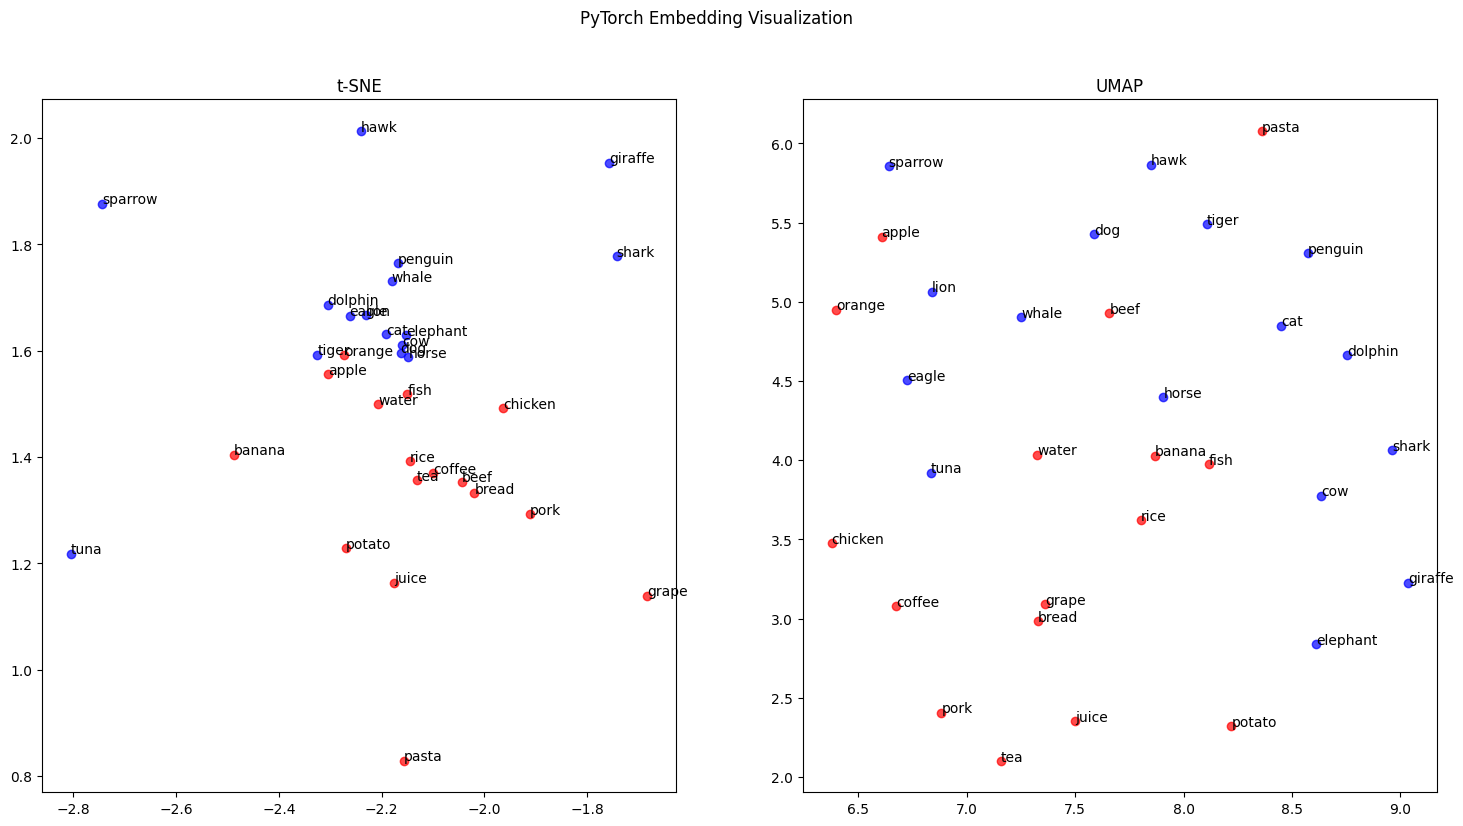

c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\02 - Winter 2026\STAT 359\stat359\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


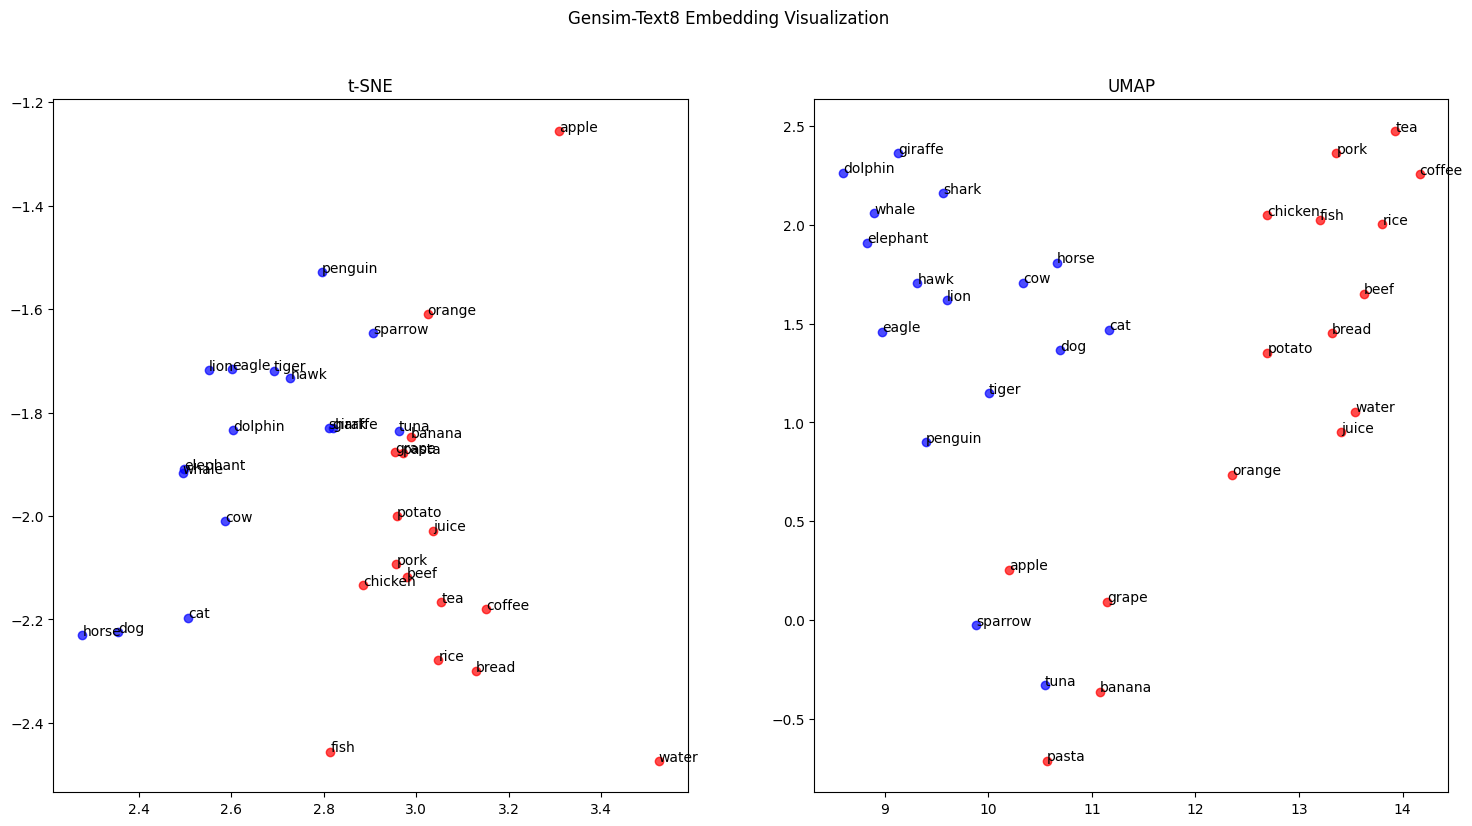

c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\02 - Winter 2026\STAT 359\stat359\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


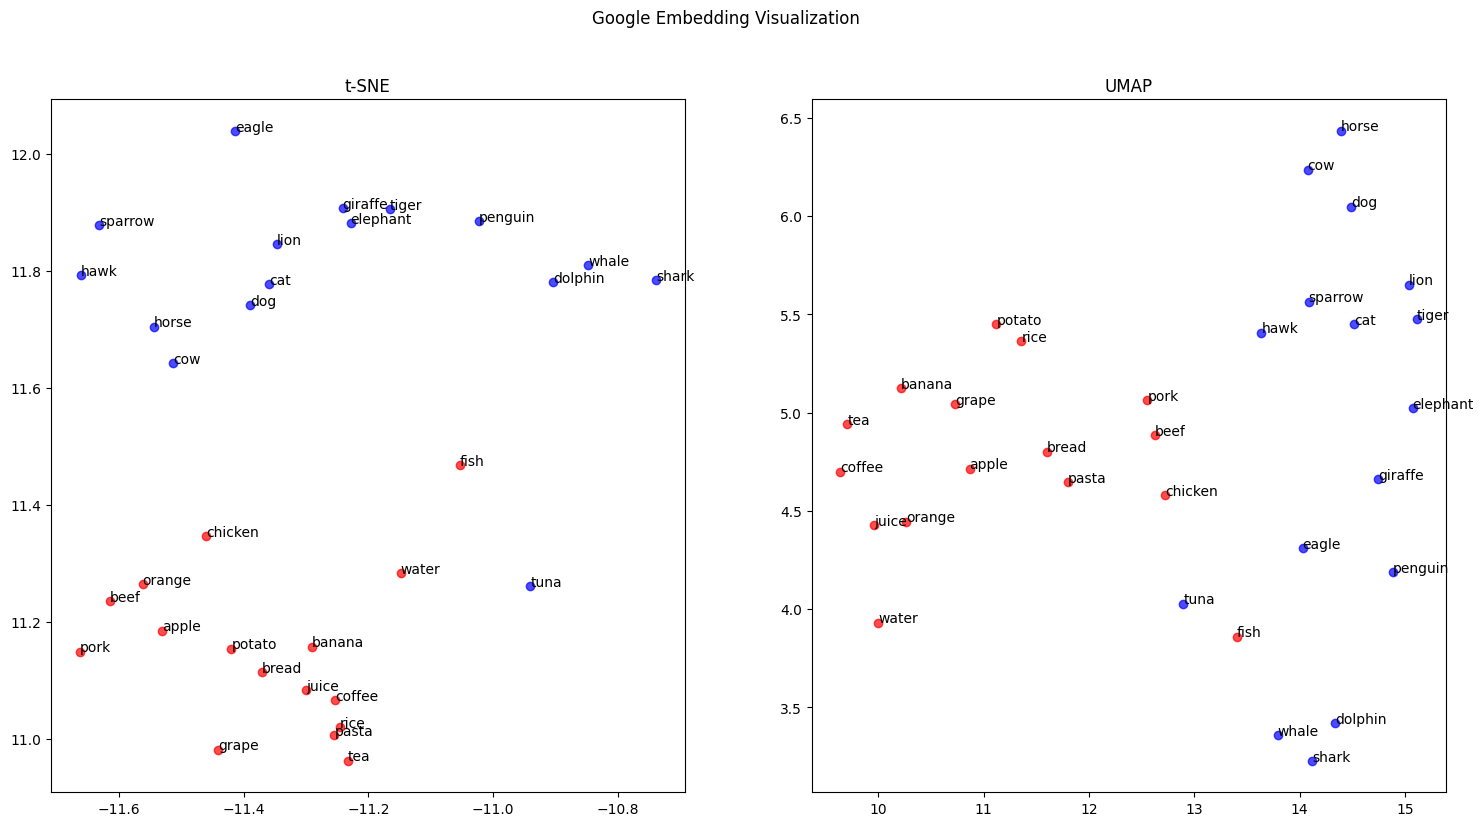

c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\02 - Winter 2026\STAT 359\stat359\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


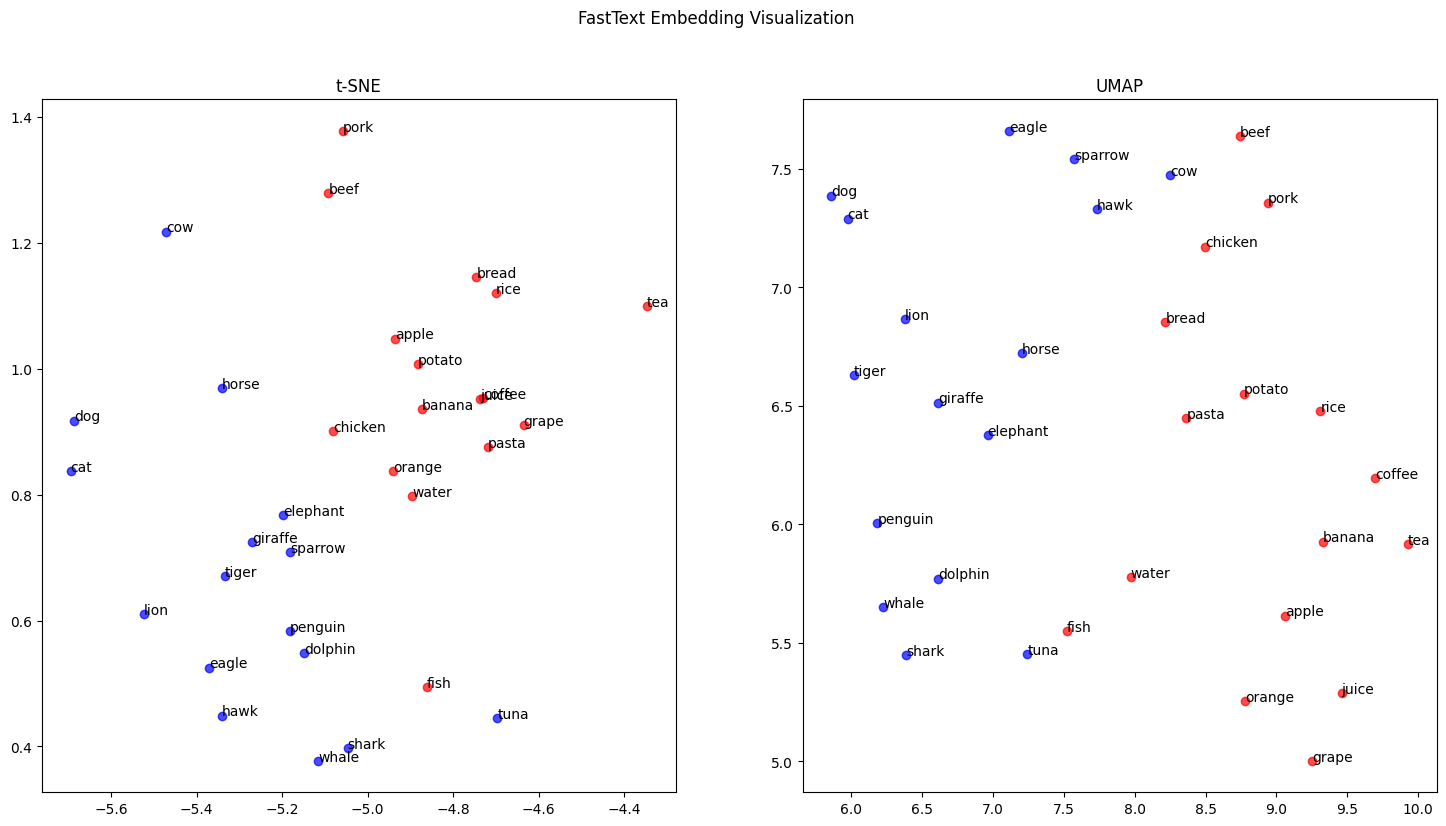

In [31]:
for name, m_type in models:
    embedding_visualizer(name, m_type)

The separation between categories is relatively consistent across t-SNE embedding visualizations, roughly in half. The UMAP visualizations show less clustering in the worse performing models, likely more indicative of actual model performance. Further clustering can be seen wihtin the mappings across categories like fish being near tuna for FastText t-SNE.

## Short Answer Questions

### Which embeddings performed best at capturing sentence meaning?

The pretrained fasttext gensim model performed the best at capturing sentence meaning, where it acurately identified the closest semantic sentences to the query. The similarity was the highest of all the models, leaning into why I believe it was the best at capturing meaning. The Google News gensim model was second best, identifying the same sentences as closest in meaning but with lower scores. The pytorch self-made model performed the worst, falsely identifying an unrelated model as being the most semantically similar.


### Where the pretained embedding significantly better than your own? Why or why not?

The pretrianed embedding were significantly better as they far out performed on sentence semantic comparison than my model as well as showing clearer clustering in the embedding visualizations.


### What factors might explain the differences in performance?

The larger training corpus and more complex architecture of the pre-trained models mean they have had more exposure to words (so better able to embed them) and a more complex architecture that can handle multiple meanings more cleanly. Fasttext was the best model, which is patialy explained by it using subword information.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>
